# 02.Keras Functional of Tensorflow 2.1

__author__ = "Trung Phong Le"<br>
__email__ = "letrungphong95@gmail.com"<br>
__startDate__ = "19/01/2020"<br>
__version__ = "0.0.1"<br>
__status__ = "Being a Magical Dev"<br>
__maintainer__ = "Trung Phong Le"

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os 
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.1.0


## 2.1 Loading MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist 

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255.0
# Split training data to train and validation data
x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]
print("=======> Number of training images: ", x_train.shape[0], ".Shape: ", x_train.shape)
print("=======> Number of validation images: ", x_val.shape[0], ".Shape: ", x_val.shape)
print("=======> Number of testing images: ", x_test.shape[0], ".Shape: ", x_test.shape)

=======> Number of training images:  50000 .Shape:  (50000, 28, 28, 1)
=======> Number of validation images:  10000 .Shape:  (10000, 28, 28, 1)
=======> Number of testing images:  10000 .Shape:  (10000, 28, 28, 1)


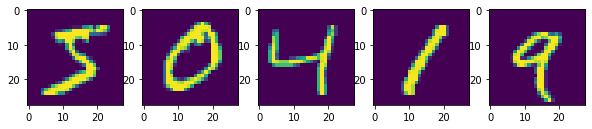

In [3]:
# Visualize data
plt.figure(figsize=(10, 10))
for i, image in enumerate(x_train[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(image.reshape(28, 28))

## 2.2 Building Keras Functional model

In [4]:
# Import related packages
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.applications.vgg16 import VGG16
# Parameters
CLASSES, H, W, D = 10, 28, 28, 1
input_shape = (H, W, D)
is_finetune = False #If set True, we should reshape data from (28,28,1) to (224,224,3) before training

In [5]:
# Define model structure
# Input 
if not is_finetune:
    inputs = Input(shape=(28, 28, 1))
    # C1 => Relu
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid', name='C1')(inputs)
    # P1 => Maxpooling 
    x = MaxPool2D(pool_size=(2,2), padding='valid', name='P1')(x)
    # Flatten 
    x = Flatten(name='Flatten')(x)
    # Full connected => Relu
    x = Dense(units=128, activation='relu', name='F1')(x)
    # Output softmax classification
    x = Dense(units=10, activation='softmax', name='output')(x)
    """ Create model """
    model = Model(inputs, x, name='Functional_Keras_model_type')
    model.summary()
else:
    # Finetune from vgg16 model
    inputs = Input(shape=(224, 224, 3))
    model_vgg16 = VGG16(weights='imagenet', include_top=False)
    output_vgg16 = model_vgg16(inputs)
    x = Flatten(name='Flatten')(output_vgg16)
    x = Dense(units=4096, activation='relu', name='fc1')(x)
    x = Dense(units=4096, activation='relu', name='fc2')(x)
    x = Dense(units=10, activation='softmax', name='output')(x)
    """ Create model """
    model = Model(inputs, x, name='Functional_Keras_model_type')
    model.summary()

Model: "Functional_Keras_model_type"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
C1 (Conv2D)                  (None, 26, 26, 32)        320       
_________________________________________________________________
P1 (MaxPooling2D)            (None, 13, 13, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
F1 (Dense)                   (None, 128)               692352    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________

## 2.3 Training model

In [6]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
# Hyperparameters 
LR = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 2

In [7]:
# Initialize the optimizer and compile the model
opt = SGD(lr=LR, momentum=0.9, decay=LR/NUM_EPOCHS)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=opt,
             metrics=["accuracy"])
# Save checkpoints 
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
filepath = "checkpoints/CNN-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=0,
                             save_weight_only=False, save_best_only=False, mode='max')
# Train model 
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                    validation_data = (x_val, y_val), verbose=1, callbacks=[checkpoint])

# Save final model
model.save('checkpoints/final_model.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 15s 307us/sample - loss: 0.4532 - accuracy: 0.8689 - val_loss: 0.2154 - val_accuracy: 0.9406
Epoch 2/2
50000/50000 [==============================] - 14s 273us/sample - loss: 0.2138 - accuracy: 0.9371 - val_loss: 0.1862 - val_accuracy: 0.9468


In [8]:
# Test on testing data
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

10000/10000 [==============================] - 1s 132us/sample - loss: 0.1890 - accuracy: 0.9443
Test loss:  0.1889621825441718
Test accuracy:  0.9443


## 2.4 Predicting model

In [9]:
result = model.predict(x_test)
print("Result shape: ", result.shape)

Result shape:  (10000, 10)


True label:  1
Predicted label:  1


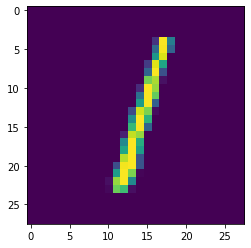

In [10]:
idx = 2
print("True label: ", y_test[idx])
print("Predicted label: ", np.argmax(result[idx]))
plt.imshow(np.squeeze(x_test[idx]))
plt.show()

## 2.5 Loading saved model

In [11]:
new_model = load_model('checkpoints/final_model.h5')
new_model.summary()

Model: "Functional_Keras_model_type"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
C1 (Conv2D)                  (None, 26, 26, 32)        320       
_________________________________________________________________
P1 (MaxPooling2D)            (None, 13, 13, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
F1 (Dense)                   (None, 128)               692352    
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________

In [12]:
# Test on testing data
test_loss, test_acc = new_model.evaluate(x_test, y_test)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

10000/10000 [==============================] - 2s 152us/sample - loss: 0.1890 - accuracy: 0.9443
Test loss:  0.1889621825441718
Test accuracy:  0.9443
